In [1]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
path = '/kaggle/input/mushrooms-classification-common-genuss-images/mushrooms/Mushrooms/'
df = pd.DataFrame()
for imlabel in os.listdir(path):
    for image in os.listdir(path+imlabel):
        df = df.append({"path" : path+imlabel+"/"+image, "label" : imlabel}, ignore_index=True)

df.head()

,path,label
0,/kaggle/input/mushrooms-classification-common-...,Entoloma
1,/kaggle/input/mushrooms-classification-common-...,Entoloma
2,/kaggle/input/mushrooms-classification-common-...,Entoloma
3,/kaggle/input/mushrooms-classification-common-...,Entoloma
4,/kaggle/input/mushrooms-classification-common-...,Entoloma


## Splitting Data :
70%, 20%, 10% for training, validation and testing respecitvely

In [3]:
train_X, val_test_X, train_Y, val_test_Y = train_test_split(df['path'], df['label'], test_size=0.3, shuffle=True)
train_data = pd.concat({'path':train_X, 'label':train_Y}, axis=1)

val_X, test_X, val_Y, test_Y = train_test_split(val_test_X, val_test_Y, test_size=0.33, shuffle=True)

validation_data = pd.concat({'path':val_X, 'label':val_Y}, axis=1)
test_data = pd.concat({'path':test_X, 'label':test_Y}, axis=1)

In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
vertical_flip = True)
train_data_generator = train_datagen.flow_from_dataframe(train_data,
                                                         x_col = 'path',
                                                         y_col = 'label',
                                                        batch_size=32,
                                                         color_mode="rgb",
                                                         target_size=(224, 224),
                                                        class_mode="categorical")
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_data_generator = validation_datagen.flow_from_dataframe(validation_data,
                                                                   x_col = 'path',
                                                                   y_col = 'label',
                                                                   batch_size=32,
                                                                   color_mode="rgb",
                                                                   target_size=(224, 224),
                                                                   class_mode="categorical")

test_datagen = ImageDataGenerator(rescale=1./255)
test_data_generator = test_datagen.flow_from_dataframe(test_data,
                                         x_col = 'path',
                                          y_col = 'label',
                                          batch_size=test_data['path'].shape[0],
                                          color_mode="rgb",
                                          target_size=(224, 224),
                                          class_mode="categorical")

Found 4699 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 665 validated image filenames belonging to 9 classes.


In [5]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint ,EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report

In [6]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + 
    K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

2022-01-17 13:27:29.616907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-17 13:27:29.701014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-17 13:27:29.701680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-17 13:27:29.702785: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

29097984/29084464 [==============================] - 0s 0us/step


In [8]:
xceptionNet = tensorflow.keras.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
)

83697664/83683744 [==============================] - 0s 0us/step


In [9]:
img_inputs = tensorflow.keras.Input(shape=(224, 224, 3))

x = densenet(img_inputs)
x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
x = tensorflow.keras.layers.Dense(128, activation='relu')(x)

y = xceptionNet(img_inputs)
y = tensorflow.keras.layers.GlobalAveragePooling2D()(y)
y = tensorflow.keras.layers.Dense(128, activation='relu')(y)

y = tensorflow.keras.layers.Concatenate()([x, y])
m_output = tensorflow.keras.layers.Dense(9, activation='softmax')(y)

model2 = keras.Model(inputs=img_inputs, outputs=m_output)

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1_m, precision_m, recall_m])
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
densenet121 (Functional)        (None, 7, 7, 1024)   7037504     input_3[0][0]                    
__________________________________________________________________________________________________
xception (Functional)           (None, 7, 7, 2048)   20861480    input_3[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1024)         0           densenet121[0][0]                
______________________________________________________________________________________________

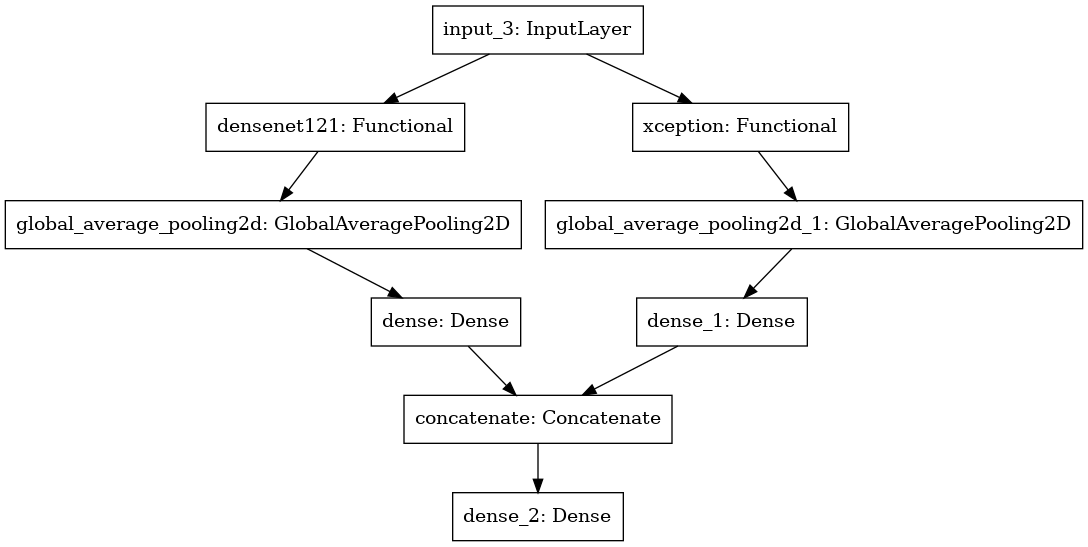

In [10]:
tensorflow.keras.utils.plot_model(model2)

In [11]:
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

early = EarlyStopping(monitor='val_accuracy', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.09,patience=2)

history = model2.fit(train_data_generator, epochs=2, validation_data=validation_data_generator, callbacks=[early, reduce_lr])

2022-01-17 13:27:38.783228: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2


2022-01-17 13:27:54.009293: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


147/147 [==============================] - 187s 1s/step - loss: 1.4128 - accuracy: 0.5210 - f1_m: 0.4520 - precision_m: 0.6830 - recall_m: 0.3465 - val_loss: 4.0555 - val_accuracy: 0.3541 - val_f1_m: 0.3488 - val_precision_m: 0.3613 - val_recall_m: 0.3375
Epoch 2/2
147/147 [==============================] - 130s 882ms/step - loss: 1.0201 - accuracy: 0.6497 - f1_m: 0.6246 - precision_m: 0.7635 - recall_m: 0.5314 - val_loss: 10.5650 - val_accuracy: 0.2119 - val_f1_m: 0.2123 - val_precision_m: 0.2143 - val_recall_m: 0.2103


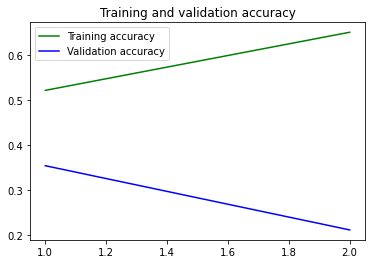

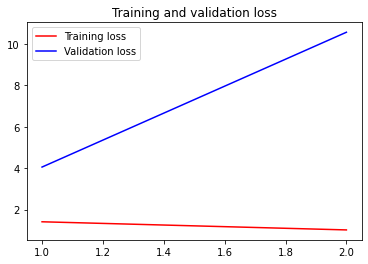

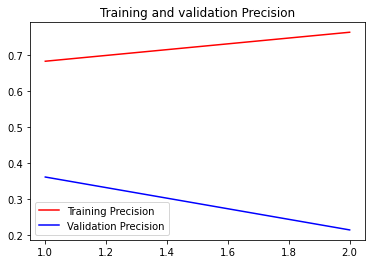

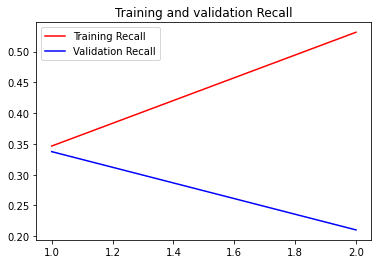

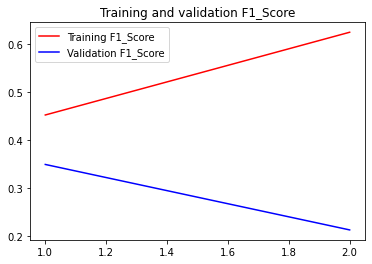

In [15]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision_m']
val_precision = history.history['val_precision_m']
recall = history.history['recall_m']
val_recall = history.history['val_recall_m']
f1_score = history.history['f1_m']
val_f1_score = history.history['val_f1_m']

import matplotlib.pyplot as plt

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, precision, 'r', label='Training Precision')
plt.plot(epochs, val_precision, 'b', label='Validation Precision')
plt.title('Training and validation Precision')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'r', label='Training Recall')
plt.plot(epochs, val_recall, 'b', label='Validation Recall')
plt.title('Training and validation Recall')
plt.legend()

plt.figure()

plt.plot(epochs, f1_score, 'r', label='Training F1_Score')
plt.plot(epochs, val_f1_score, 'b', label='Validation F1_Score')
plt.title('Training and validation F1_Score')
plt.legend()
plt.show()

In [16]:
for image, lab in test_data_generator:
    break;

predict_y = model2.predict(image)

## Confusion Matrix heatmap

[Text(0.5, 15.0, 'prediction'), Text(33.0, 0.5, 'true_value')]

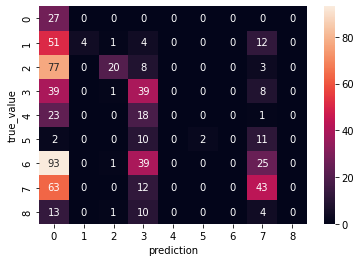

In [19]:
import seaborn as sns

cnf = tensorflow.math.confusion_matrix(np.argmax(lab, axis=1), np.argmax(predict_y, axis=1))
c_plot = sns.heatmap(cnf, annot=True)
c_plot.set(xlabel='prediction', ylabel='true_value')

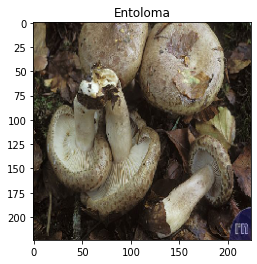

Wrong value prediction
Correct label is : Russula


In [18]:
def show_predicted_image(i):
    plt.imshow(image[i])
    plt.title(os.listdir(path)[np.argmax(predict_y[i])])
    plt.show()
    if (np.argmax(predict_y[i])==np.argmax(lab[i])):
        print("True prediction")
    else:
        print("Wrong value prediction")
        print(f"Correct label is : {os.listdir(path)[np.argmax(lab[i])]}")
        
show_predicted_image(4)

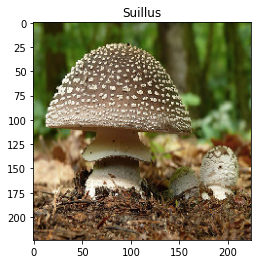

True prediction


In [24]:
show_predicted_image(17)

## Test data Classification Report : 

## Classification report for test datset

In [25]:
print(classification_report(np.argmax(lab, axis=1), np.argmax(predict_y, axis=1)))

              precision    recall  f1-score   support

           0       0.07      1.00      0.13        27
           1       1.00      0.06      0.11        72
           2       0.83      0.19      0.30       108
           3       0.28      0.45      0.34        87
           4       0.00      0.00      0.00        42
           5       1.00      0.08      0.15        25
           6       0.00      0.00      0.00       158
           7       0.40      0.36      0.38       118
           8       0.00      0.00      0.00        28

    accuracy                           0.20       665
   macro avg       0.40      0.24      0.16       665
weighted avg       0.39      0.20      0.18       665



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
